<a href="https://colab.research.google.com/github/Preteka/Deep-Learning-Lab/blob/main/dl9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - kl_loss: 7.7264 - loss: 204.8223 - recon_loss: 197.0959
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 3.1713 - loss: 171.0090 - recon_loss: 167.8378
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 3.1720 - loss: 165.2389 - recon_loss: 162.0669
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 3.2109 - loss: 162.9484 - recon_loss: 159.7376
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 3.2174 - loss: 161.3449 - recon_loss: 158.1276
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 3.2323 - loss: 160.1319 - recon_loss: 156.8997
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - kl_loss: 3.2380 - loss: 159.1310 - recon_loss: 155.8930
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - kl_loss: 3.2543 - loss: 158.2969 - recon_loss: 155.0426
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - kl_l

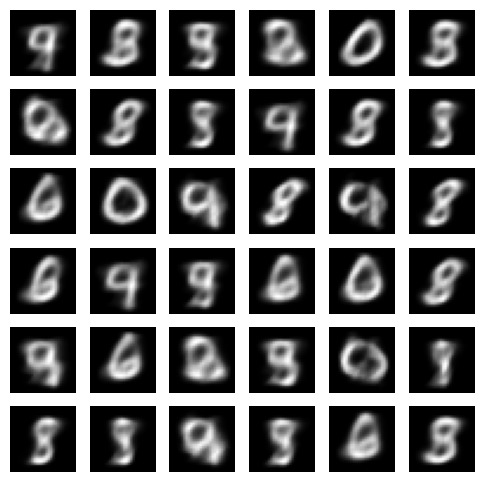

In [1]:
# Simple Variational Autoencoder (VAE) on MNIST
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

# Load MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x = np.concatenate([x_train, x_test], axis=0).astype("float32") / 255.0
x = np.expand_dims(x, -1)   # shape (70000, 28, 28, 1)

latent_dim = 2   # small latent space to visualize

# -------- Encoder --------
inputs = layers.Input(shape=(28,28,1))
x_enc = layers.Flatten()(inputs)
x_enc = layers.Dense(128, activation="relu")(x_enc)
z_mean = layers.Dense(latent_dim)(x_enc)
z_log_var = layers.Dense(latent_dim)(x_enc)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z])

# -------- Decoder --------
latent_inputs = layers.Input(shape=(latent_dim,))
x_dec = layers.Dense(128, activation="relu")(latent_inputs)
x_dec = layers.Dense(28*28, activation="sigmoid")(x_dec)
outputs = layers.Reshape((28,28,1))(x_dec)
decoder = Model(latent_inputs, outputs)

# -------- VAE Model --------
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, recon)
            ) * 28 * 28
            # KL Divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss = recon_loss + kl_loss
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(x, epochs=10, batch_size=128)

# -------- Generate Synthetic Images --------
def show_generated(n=10):
    z_samples = np.random.normal(size=(n*n, latent_dim))
    imgs = decoder.predict(z_samples)
    plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.show()

show_generated(6)   # show 6x6 = 36 synthetic images
